In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import joblib


In [3]:
dataset_dir = r'C:\Users\manog\Downloads\ecg_images'  # your folder with images person_0.png to person_89.png

# We'll make a CSV or list of (filename, label) from the file names
filepaths = []
labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.png'):
        filepaths.append(os.path.join(dataset_dir, filename))
        # Extract person id from filename: 'person_5.png' → label = 5
        label = int(filename.split('_')[1].split('.')[0])
        labels.append(label)

print(f'Total images: {len(filepaths)}')
print(f'Example: {filepaths[0]}, label={labels[0]}')


Total images: 90
Example: C:\Users\manog\Downloads\ecg_images\person_0.png, label=0


In [4]:
import pandas as pd

df = pd.DataFrame({
    'filename': filepaths,
    'label': labels
})

# Encode labels to 0 to 89 (optional, but good practice)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

print(df.head())



                                            filename  label  label_enc
0   C:\Users\manog\Downloads\ecg_images\person_0.png      0          0
1   C:\Users\manog\Downloads\ecg_images\person_1.png      1          1
2  C:\Users\manog\Downloads\ecg_images\person_10.png     10         10
3  C:\Users\manog\Downloads\ecg_images\person_11.png     11         11
4  C:\Users\manog\Downloads\ecg_images\person_12.png     12         12


In [6]:
print(df['label_enc'].value_counts())



label_enc
0     1
1     1
10    1
11    1
12    1
     ..
86    1
87    1
88    1
89    1
9     1
Name: count, Length: 90, dtype: int64


In [11]:
# Convert label_enc to string as required by flow_from_dataframe for sparse mode
df['label_enc'] = df['label_enc'].astype(str)


In [12]:
from sklearn.model_selection import train_test_split

train_df = df

print(f'Train samples: {len(train_df)}')


Train samples: 90


In [14]:
import os
import shutil
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Path to original ECG images
input_dir = 'C:/Users/manog/Downloads/ecg_images'
output_dir = 'C:/Users/manog/Downloads/ecg_augmented'
os.makedirs(output_dir, exist_ok=True)

# Load image metadata
df = pd.DataFrame({'filename': [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.png')]})
df['label'] = df['filename'].apply(lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

# Image augmentation setup
IMG_SIZE = (224, 224)
AUGMENTATIONS_PER_IMAGE = 20

augmentor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Loop through each image and create augmented samples
for index, row in df.iterrows():
    label = row['label']
    img_path = row['filename']

    # Create folder for this person
    person_dir = os.path.join(output_dir, f'person_{label}')
    os.makedirs(person_dir, exist_ok=True)

    # Load and prepare image
    img = load_img(img_path, target_size=IMG_SIZE)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)  # shape: (1, height, width, channels)

    # Generate augmentations and save
    i = 0
    for batch in augmentor.flow(x, batch_size=1, save_to_dir=person_dir, save_prefix=f'person_{label}_aug', save_format='png'):
        i += 1
        if i >= AUGMENTATIONS_PER_IMAGE:
            break

print('✅ Augmented images saved to:', output_dir)



✅ Augmented images saved to: C:/Users/manog/Downloads/ecg_augmented


In [16]:
import os
import pandas as pd

# Define the dataset path
dataset_path = r'C:/Users/manog/Downloads/ecg_augmented'

# Gather image file paths and corresponding labels
data = []
for person_folder in os.listdir(dataset_path):
    label = int(person_folder.split('_')[1])  # person_0 → 0
    person_path = os.path.join(dataset_path, person_folder)
    for img_file in os.listdir(person_path):
        if img_file.endswith('.png') or img_file.endswith('.jpg'):
            full_path = os.path.join(person_path, img_file)
            data.append((full_path, label))

# Create DataFrame
df = pd.DataFrame(data, columns=['filename', 'label'])

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Print sample and count
print(f'Total samples: {len(df)}')
print(df.head())


Total samples: 1796
                                            filename  label
0  C:/Users/manog/Downloads/ecg_augmented\person_...      9
1  C:/Users/manog/Downloads/ecg_augmented\person_...     37
2  C:/Users/manog/Downloads/ecg_augmented\person_...     83
3  C:/Users/manog/Downloads/ecg_augmented\person_...     42
4  C:/Users/manog/Downloads/ecg_augmented\person_...     18


In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split data into train and validation
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# ✅ Convert labels to strings for sparse mode
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

# Image input size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)


Found 1436 validated image filenames belonging to 90 classes.
Found 360 validated image filenames belonging to 90 classes.


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Define input shape
input_shape = (224, 224, 3)

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freeze base

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(90, activation='softmax')  # 90 classes for 90 persons
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 90)             │        23,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,400,637 (16.79 MB)

 Trainable params: 351,066 (1.34 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
DATASET_PATH = 'C:/Users/manog/Downloads/ecg_augmented'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Prepare dataframe
data = []
for label in os.listdir(DATASET_PATH):
    person_folder = os.path.join(DATASET_PATH, label)
    if os.path.isdir(person_folder):
        for file in os.listdir(person_folder):
            if file.endswith('.png'):
                data.append({
                    'filename': os.path.join(person_folder, file),
                    'label': label
                })

df = pd.DataFrame(data)

# Convert label to string (required for sparse mode)
df['label'] = df['label'].astype(str)

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)


Found 1436 validated image filenames belonging to 90 classes.
Found 360 validated image filenames belonging to 90 classes.


In [22]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),  # ECG images are RGB (even if grayscale)
    
    # Feature extractor
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # Embedding layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    # Classification layer
    layers.Dense(90, activation='softmax')  # 90 classes for person_0 to person_89
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 90)             │        11,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 434,842 (1.66 MB)

 Trainable params: 433,882 (1.66 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Callbacks to save best model and prevent overfitting
checkpoint = ModelCheckpoint('best_ecg_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


c:\Users\manog\Downloads\biometric_attendance_system\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0233 - loss: 4.4125
Epoch 1: val_accuracy improved from -inf to 0.01111, saving model to best_ecg_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.0233 - loss: 4.4102 - val_accuracy: 0.0111 - val_loss: 4.6685
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0798 - loss: 3.8326
Epoch 2: val_accuracy did not improve from 0.01111
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.0801 - loss: 3.8295 - val_accuracy: 0.0111 - val_loss: 5.8861
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1670 - loss: 3.1437
Epoch 3: val_accuracy did not improve from 0.01111
45/45 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.1673 - loss: 3.1418 - val_accuracy: 0.0111 - val_loss: 9.8691
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2992 - loss: 2.5962
Epoch 4: val_accuracy did not improve from 0.01111
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.2995 - loss: 2.5936 - val_accuracy: 0.0111 - val_loss: 14.6049
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4436 - loss: 2.0368
Epoch 5: val_accuracy did not improve from 0.01111


45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6700 - loss: 1.1822 - val_accuracy: 0.0222 - val_loss: 30.7102
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7814 - loss: 0.8514
Epoch 8: val_accuracy did not improve from 0.02222
45/45 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.7814 - loss: 0.8512 - val_accuracy: 0.0111 - val_loss: 46.1584
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8274 - loss: 0.6605
Epoch 9: val_accuracy did not improve from 0.02222
45/45 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - accuracy: 0.8274 - loss: 0.6603 - val_accuracy: 0.0111 - val_loss: 62.1767
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8350 - loss: 0.5676
Epoch 10: val_accuracy did not improve from 0.02222
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8354 - loss: 0.5671 - val_accuracy: 0.0111 - val_loss: 109.1982
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8825 - loss: 0.4444
Epoch 11: val_accuracy did not improve from

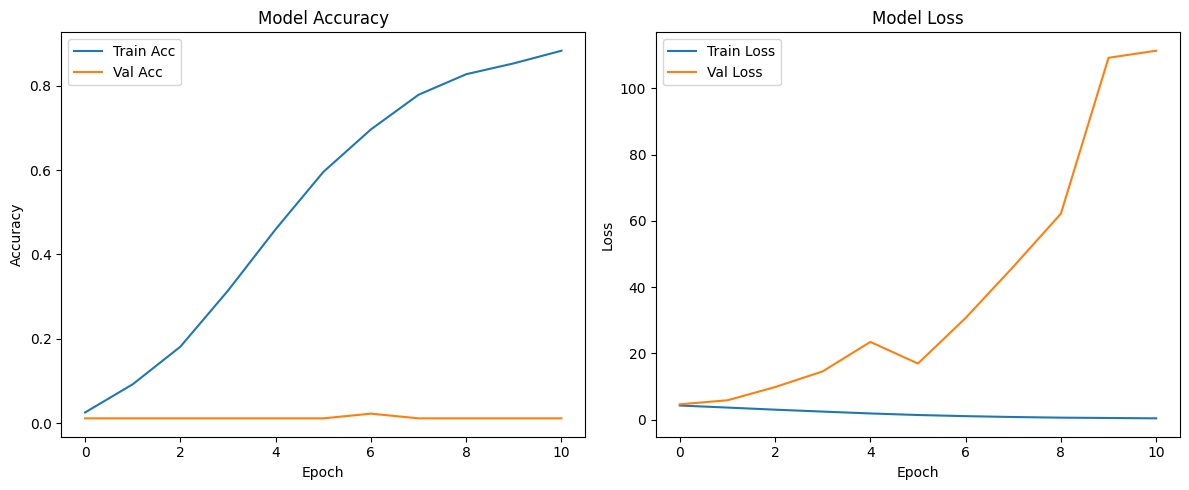

In [24]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 413ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         4
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0

c:\Users\manog\Downloads\biometric_attendance_system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manog\Downloads\biometric_attendance_system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\manog\Downloads\biometric_attendance_system\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

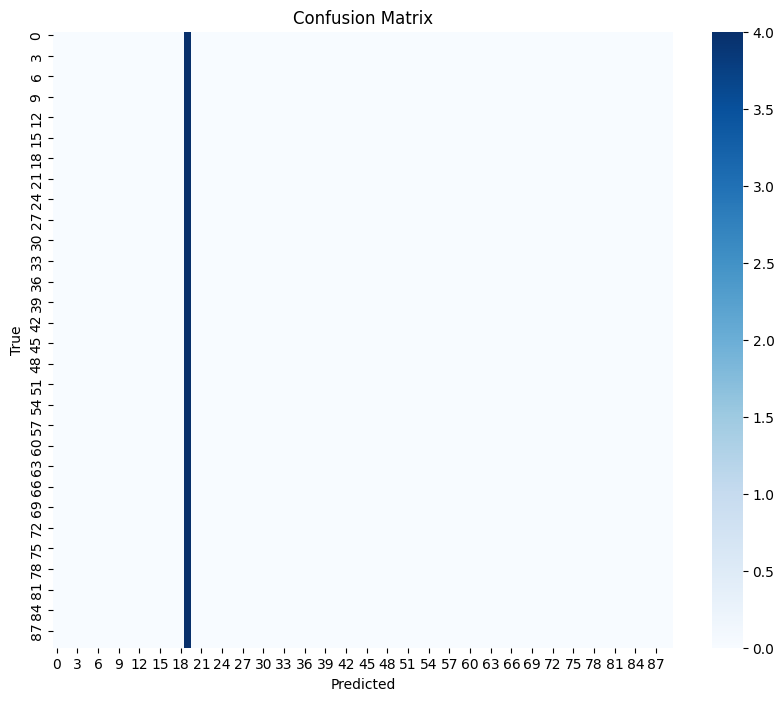

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities and classes for validation data
val_generator.reset()
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
